In [1]:
import pandas as pd
import numpy as np

import gc
import os
import sys

from multiprocessing import Pool

import operator
from collections import Counter

In [2]:
sys.path.insert(0, os.getenv("HOME") + "/workdir/MusicMap/")

from utils.mp3_to_wav import convert_one_audio
from utils.wav_file_wrapper import *

In [3]:
%matplotlib inline

In [4]:
MNT_HDD_PROJECT="/mnt/hdd/music_map_project/"
MNT_SSD_PROJECT="/mnt/ssd/musicmap_data/"

DATA_MP3 = os.path.join(MNT_HDD_PROJECT, "audio")
DATA_WAV = os.path.join(MNT_HDD_PROJECT, "audio_wav")

SPECTRO = os.path.join(MNT_SSD_PROJECT, "audio_spectro_vbugaevsky")

In [5]:
if not os.path.exists(DATA_WAV):
    os.mkdir(DATA_WAV)
    
if not os.path.exists(SPECTRO):
    os.mkdir(SPECTRO)

In [6]:
for (dirpath, dirnames, filenames) in os.walk(DATA_MP3):
    break

audio_ids = map(lambda x: os.path.splitext(x)[0], filenames)
len(audio_ids)

2802

In [7]:
np.random.seed(8888)

### Convert \*.mp3 to \*.wav

In [ ]:
if len(os.listdir(DATA_WAV)) > 0:
    raise NameError("Directory is not empty!")

try:   
    pool = Pool(processes=10)
    res = pool.map_async(convert_one_audio, zip(
        map(lambda s: s+'.mp3', audio_ids),
        [DATA_MP3] * len(audio_ids),
        [DATA_WAV] * len(audio_ids)
    ))
    res.get()
finally:
    pool.terminate()
    pool.join()

### Inspect audios length

In [ ]:
audio_lengths = dict()

for i, audio in enumerate(audio_ids):
    wav_file = WavFile.read(os.path.join(DATA_WAV, audio+'.wav'))
    audio_lengths[audio] = len(wav_file)
    if (i + 1) % 100 == 0:
        print i + 1

In [ ]:
audio_lengths_grouped = sorted(
    list(Counter(audio_lengths.values()).iteritems()),
    key=operator.itemgetter(0)
)
audio_lengths_grouped

In [ ]:
len(filter(lambda x: x[0] > 45, audio_lengths_grouped))

### Bootstrap spectros

In [ ]:
def bootstrap_spectros(audio_id):
    wav_file = WavFile.read(os.path.join(DATA_WAV, audio_id+'.wav'))
    for offset, subsample in bootstrap_track(wav_file, nb_secs=30, size=1):
        save_spectrogram(subsample, os.path.join(
            SPECTRO, "{}_{:04}.png".format(audio_id, offset)
        ), size=(256, 215))
    print audio_id+".png"

In [ ]:
if len(os.listdir(SPECTRO)) > 0:
    raise NameError("Directory is not empty!")

try:
    pool = Pool(processes=15)
    res = pool.map_async(bootstrap_spectros, audio_ids)
    res.wait()
finally:
    pool.terminate()
    pool.join()

### Split by train and test

In [21]:
df = pd.read_csv("/mnt/hdd/music_map_project/balanced_audio_target.csv", index_col=0)
df.head()

,song_filename,valence,arousal
0,7D,5.8,6.4
1,8D,3.2,4.8
2,25D,7.9,4.7
3,31D,4.7,3.8
4,37D,6.6,5.3


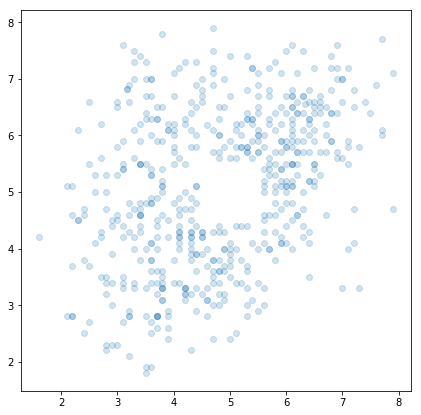

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(df["valence"], df["arousal"], alpha=0.2)

In [23]:
audios_va = dict(zip(df.values[:,0], map(list, list(df.values[:,1:]))))

In [24]:
dataset = []

for (dirpath, dirnames, filenames) in os.walk(SPECTRO):
    for spectro_name in filenames:
        audio_id = spectro_name.split('_')[0]
        if audio_id in audios_va:
            dataset.append([spectro_name] + audios_va[audio_id])
        
dataset = pd.DataFrame(dataset, columns=df.columns)

In [25]:
border = int(0.9 * dataset.shape[0])
index = np.arange(dataset.shape[0])
np.random.shuffle(index)
index_train, index_valid = index[:border], index[border:]

In [26]:
df_train = dataset.iloc[index_train]
df_valid = dataset.iloc[index_valid]

In [27]:
SPECTRO_CSV = SPECTRO + "_csv"

if not os.path.exists(SPECTRO_CSV):
    os.mkdir(SPECTRO_CSV)

In [28]:
df_train.to_csv(os.path.join(SPECTRO_CSV, "train.csv"), index=False)
df_valid.to_csv(os.path.join(SPECTRO_CSV, "valid.csv"), index=False)

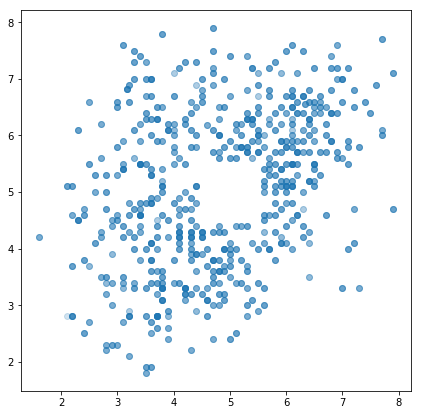

In [29]:
plt.figure(figsize=(7,7))
plt.scatter(df_train["valence"], df_train["arousal"], alpha=0.2)

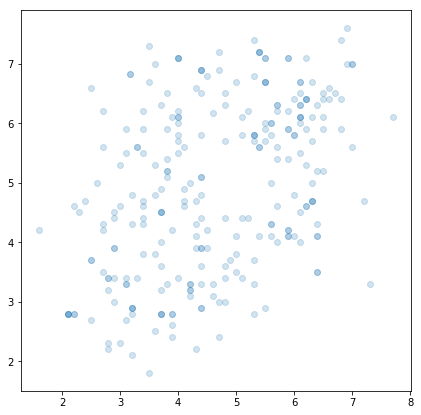

In [30]:
plt.figure(figsize=(7,7))
plt.scatter(df_valid["valence"], df_valid["arousal"], alpha=0.2)

In [31]:
len(df_train) + len(df_valid) == len(df)

False

In [32]:
len(df_train), len(df_valid), len(df)

(2407, 268, 535)